In [1]:
%load_ext autoreload
%autoreload 1
%aimport scorer_class
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from copy import deepcopy
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%html
<style>
div.jupyter-widgets.widget-label {display: none;}
</style>

In [6]:
window_sec1, window_sec2 = 10, 10 # длина эпохи в секундах (для разделения по дельта-активноасти NREM-vs-rest и для разделения REM-vs-rest, соответственно)
n_hours_cycle = 12 # количество часов в одном цикле для отдельного определения порогов для разделения по дельта-активноасти NREM-vs-rest
n_hours_cycle_rem = 24 # количество часов в одном цикле для отдельного определения порогов для разделения по дельта-активноасти REM-vs-rest
depr = [0, 0, 0, 0] # *** has no effect for now *** 

save_pickle = False
skip_minutes = [0, 0, 0, 0, 0, 0, 0, 0, 0] # столько значений, сколько каналов в файле

pre_filt = None # либо None, либо положительное число (частота в Герцах для ФВЧ, ятобы отсеить лишнее перед анализом)
delta_mode = 'cluster' # 'band' #режим разделения по первому порогу
theta_mode = 'cluster' # many требует 3 диапазона
visualize_clusters = False # рисовать ли графики кластеризаций

smooth_fft = True # сглаживать ли данные для кластеризации
w = 30 # окно сглаживания данных с помощью rms перед кластеризацией

# delta_cluster_bands = ((2, 16), (2, 6), (2, 4), (3, 5), (2, 5)) #(3, 4), (2, 4), (12, 14), (14, 16)
# delta_cluster_bands = ((2, 16), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5)) #(3, 4), (2, 4), (12, 14), (14, 16)
delta_cluster_bands = ((2, 16), (2, 4), (3, 5), (2, 5), (12, 14), (14, 16)) #(3, 4), (2, 4), (12, 14), (14, 16)

deltas_for_rem = [] # варианты дельты для голосования при отделения верхгнего кластера при нахождении REM

w_nr_cluster_strictness = 0.5 # необходимая доля голосов от кластеров вышеуказанных диапазонов для определения NREM
theta = (8, ) # частотный диапазон тета 
spindles = False
filt_params={'length': 1501, 'transition': 0.6, 'window': 'kaiser'}
theta_cluster_params = {
                    'ranges': [], # ПЕРЕЧИСЛЯЕМ ВСЕ ~ТЕТА-ДИАПАЗОНЫ ДЛЯ КЛАСТЕРИЗАЦИИ
                    'degrees': [1],              # ПЕРЕЧИСЛЯЕМ СТЕПЕНИ ДЛЯ КЛАСТЕРИЗАЦИИ
                    'log': [False],           # ПЕРЕЧИСЛЯЕМ ВАРИАНТЫ ЛОГАРИФМИРОВАНИЯ, МОЖНО ОСТАВИТЬ ДАЖЕ КАКОЙ-ТО ОДИН
                    'welch': [False],          # ПЕРЕЧИСЛЯЕМ ВАРИАНТЫ НЕ-/ИСПОЛЬЗОВАНИЯ МЕТОДА УЭЛЧА, ТОЖЕ МОЖНО ОСТАВИТЬ КАКОЙ_ТО ОДИН
                    'ratio': [False],    # ПЕРЕЧИСЛЯЕМ ВАРИАНТЫ НЕ-/ИСПОЛЬЗОВАНИЯ RATIO
                    'mode': 'multiD', # 2D
                }
delta_ref_bands_red = []

parts = 1 # количество кусков при кластеризация REM
red_mask = False # использовать ли "прерывистые красненькие"
cluster_artifact = 'outside_ridges' # отсеивание артефактов по кластеризации в самом конце; other options: 'everywhere', False

n_hours_cycle_bars = 12 # количество часов в цикле для гистограмм по соотношению стадий
minutes = 60 # количество минут эпохи анализа для расчета динамики соотношения стадий
hours_fragm = 12 # длина цикла в часах для расчета статистики по фрагментации стадий

verbose = 1 # 0 - никаких графиков, 1 - основные графикиб 2 - все возсожные графики 
expert_hypnos = None

dir_ = r"D:\LA\data"  
fnames = [r'mouse_1.smr']#sorted(glob(os.path.join(dir_,'*.smr')))

In [7]:
# mice
delta_theta_combs = [
[(6, 10), (2, 10)],
[(6, 9), (2, 10)],
[(6, 9), (2, 9)],
[(6, 10), (2, 9)],
[(6, 10), (2, 8)],
[(6, 10), (2, 11)],
[(6, 9), (2, 11)],
[(6, 9), (2, 8)],
[(6, 9), (2, 7)],
[(6, 10), (2, 16)],

[(6, 10), (2, 7)],
[(6, 9), (3, 10)],
[(5, 9), (2, 10)],
[(6, 10), (2, 12)],
[(6, 10), (3, 10)],
[(6, 10), (2, 13)],
[(6, 10), (2, 15)],
[(6, 10), (2, 14)],
[(5, 10), (2, 10)],
[(6, 10), (3, 7)],

[(5, 9), (2, 11)],
[(6, 9), (2, 12)],
[(6, 9), (2, 14)],
[(6, 10), (3, 5)],
[(6, 9), (2, 16)],
[(6, 10), (2, 5)],
[(6, 9), (2, 5)],
[(6, 10), (2, 6)],
[(6, 9), (2, 6)],
[(6, 9), (2, 13)],

# # [(6, 9), (2, 15)],
# # [(5, 9), (3, 10)],
# # [(6, 10), (3, 8)],
# # [(5, 10), (2, 11)],
# # [(5, 10), (2, 9)],
# # [(5, 10), (3, 10)],
# # [(5, 9), (2, 9)],
# # [(6, 9), (3, 7)],
# # [(6, 9), (3, 5)],
# # [(6, 10), (3, 6)],
# # [(5, 9), (2, 7)],
# # [(5, 10), (2, 7)],
# # [(6, 9), (3, 8)],
# # [(5, 9), (2, 8)],
# # [(5, 10), (2, 8)],
# # [(5, 9), (3, 7)],
# # [(6, 9), (3, 6)],
# # [(6, 10), (2, 4)],
# # [(5, 9), (2, 12)],
# # [(5, 10), (2, 12)]   
]


In [6]:
# # rats
# delta_theta_combs = [
# [(5, 9), (2, 4)],
# [(5, 9), (2, 5)],
# [(5, 8), (2, 4)],
# [(5, 8), (2, 5)],
# [(5, 10), (2, 5)],
# [(5, 9), (3, 5)],
# [(6, 9), (2, 4)],
# [(6, 8), (2, 4)],
# [(5, 9), (2, 6)],
# [(6, 9), (2, 5)],

# [(6, 8), (2, 5)],
# [(5, 8), (3, 5)],
# [(5, 8), (2, 6)],
# [(5, 10), (3, 5)],
# [(5, 10), (2, 4)],
# [(6, 9), (3, 5)],
# [(5, 10), (2, 6)],
# [(5, 9), (2, 7)],
# [(6, 9), (2, 6)],
# [(6, 8), (3, 5)],
    
# [(6, 8), (2, 6)],
# [(5, 8), (2, 7)],
# [(6, 10), (2, 5)],
# [(6, 10), (2, 4)],
# [(5, 10), (2, 7)],
# [(6, 10), (2, 6)],
# [(6, 10), (3, 5)],
# [(6, 9), (2, 7)],
# [(5, 9), (3, 6)],
# [(6, 8), (2, 7)],
# ]

# Provide expert REM hypnograms if there are any (txt files with names being identical to smr files' names)

In [8]:
# scorer_class.DATA_EXTENSION = 'smr'
fnames_ = [r'mouse_1.txt']  # имена должны быть такие же, как и имена соответствующих файлов с данными, кроме расширения; 
# столбцы соответствуют гипнограммам всех дней (второй индекс) всех животных (первый индекс), т.е. для 2 дней 2 животных последовательность 0_0, 0_1, 1_0, 1_1
expert_hypnos = scorer_class.read_hypnos(fnames_, dir_)


D:\LA\data\mouse_1.txt [0 1 2 3 8]


# Analysis

### Подготовка данных (без артефактов и NREM)

In [9]:
%matplotlib inline
# fnames = [r'mouse_2.smr']#sorted(glob(os.path.join(dir_,'*.smr')))

save_dir = dir_ # папка для сохранения результатов


hypno_labels, last_hypnos, fracs, fragms, hypnos, saved_specs = {}, {}, {}, {}, {}, {}
vote_dict, scoring, scorings = scorer_class.prescoring(fnames, dir_, window_sec1=window_sec1, window_sec2=window_sec2, n_hours_cycle=n_hours_cycle, delta_cluster_bands=delta_cluster_bands, theta=theta, delta_mode=delta_mode, verbose=verbose, \
                                         theta_mode=theta_mode, filt_params=filt_params, pre_filt=pre_filt, depr=depr, spindles=spindles, cluster_strictness=w_nr_cluster_strictness, delta_ref_bands_red=delta_ref_bands_red, \
                                         theta_cluster_params=theta_cluster_params, red_mask=red_mask, n_back=1, w_nr_cluster_strictness=w_nr_cluster_strictness, smooth_fft=smooth_fft, w=w, cluster_artifact=cluster_artifact, \
                                        visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, parts=parts, force_art_thr=[], w_humps=None, save_pickle=save_pickle, skip_minutes=skip_minutes, ep=[])

File "mouse_1.smr"
Animal 0
Day 0
Non-integer sampling rate 193.5734 correction started... Done.
24.00 hours of data loaded. 2 cycles of 12 hours each, sf = 194
Preparing data...smoothing deltas... Done
smoothing raw RMS... Done.


### Два вида выделения артефактов + вырезание горбов

File "mouse_1.smr"
Animal 0


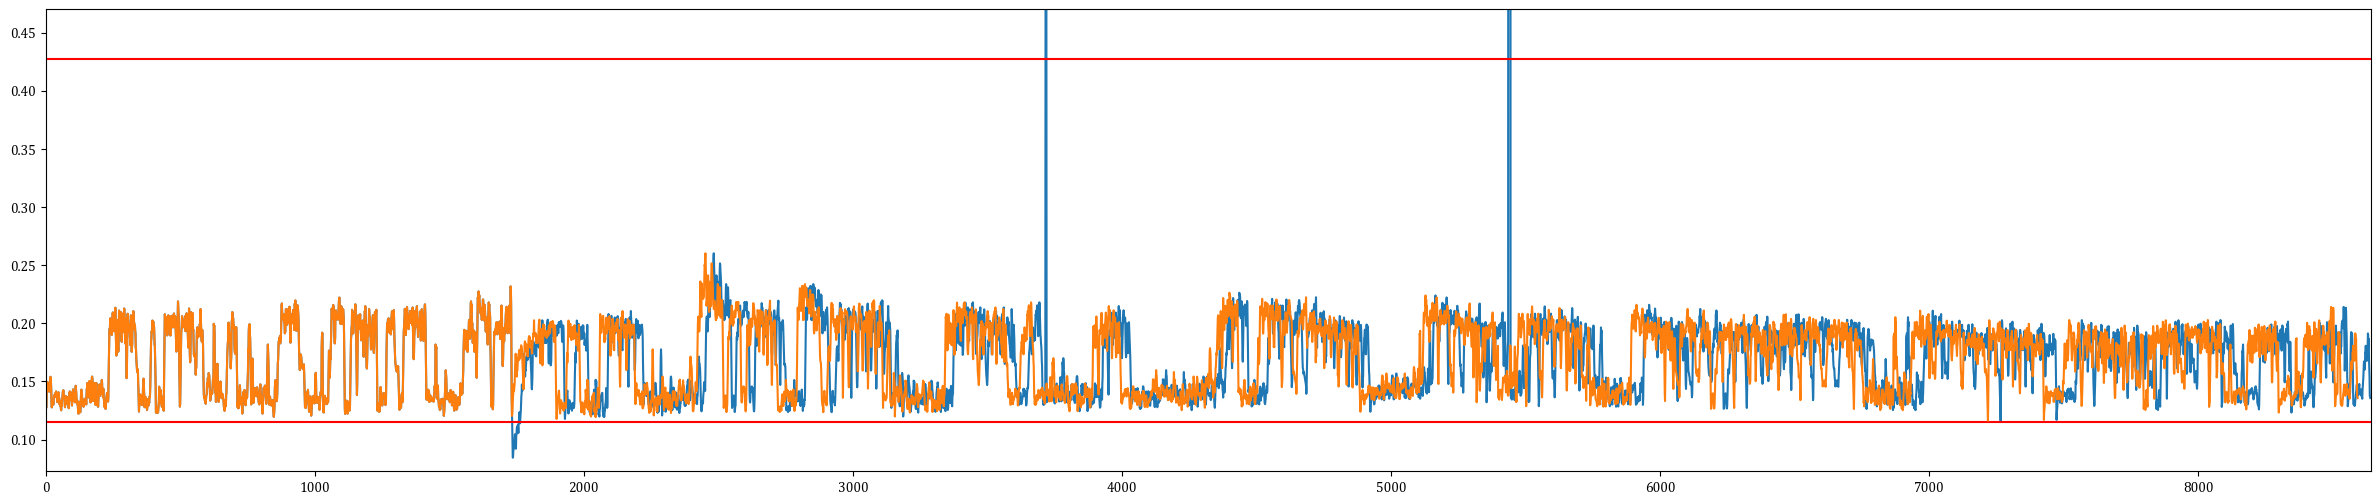

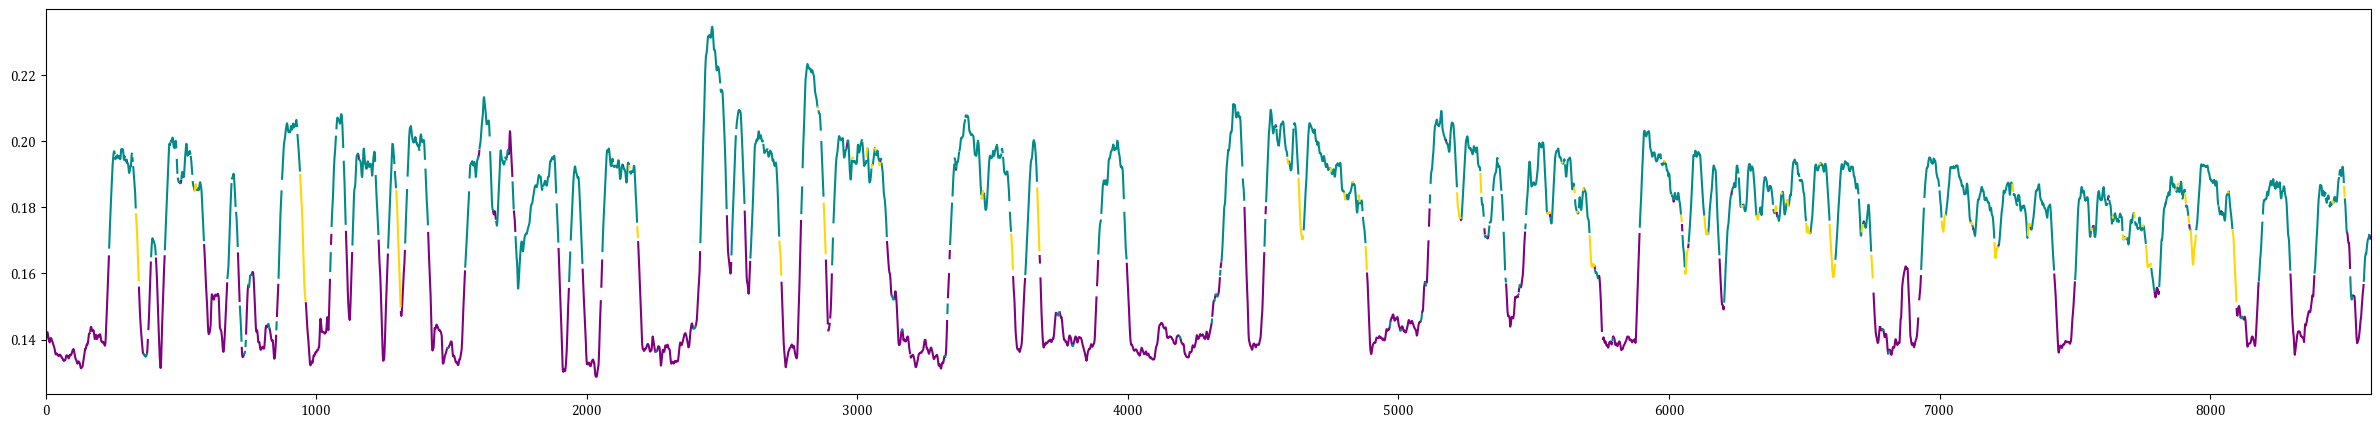

1th threshold too high 0.15 (lower mean = 0.139, upper mean = 0.186, range = 0.048), lowering to 0.143
2th threshold too high 0.16 (lower mean = 0.143, upper mean = 0.183, range = 0.040), lowering to 0.147


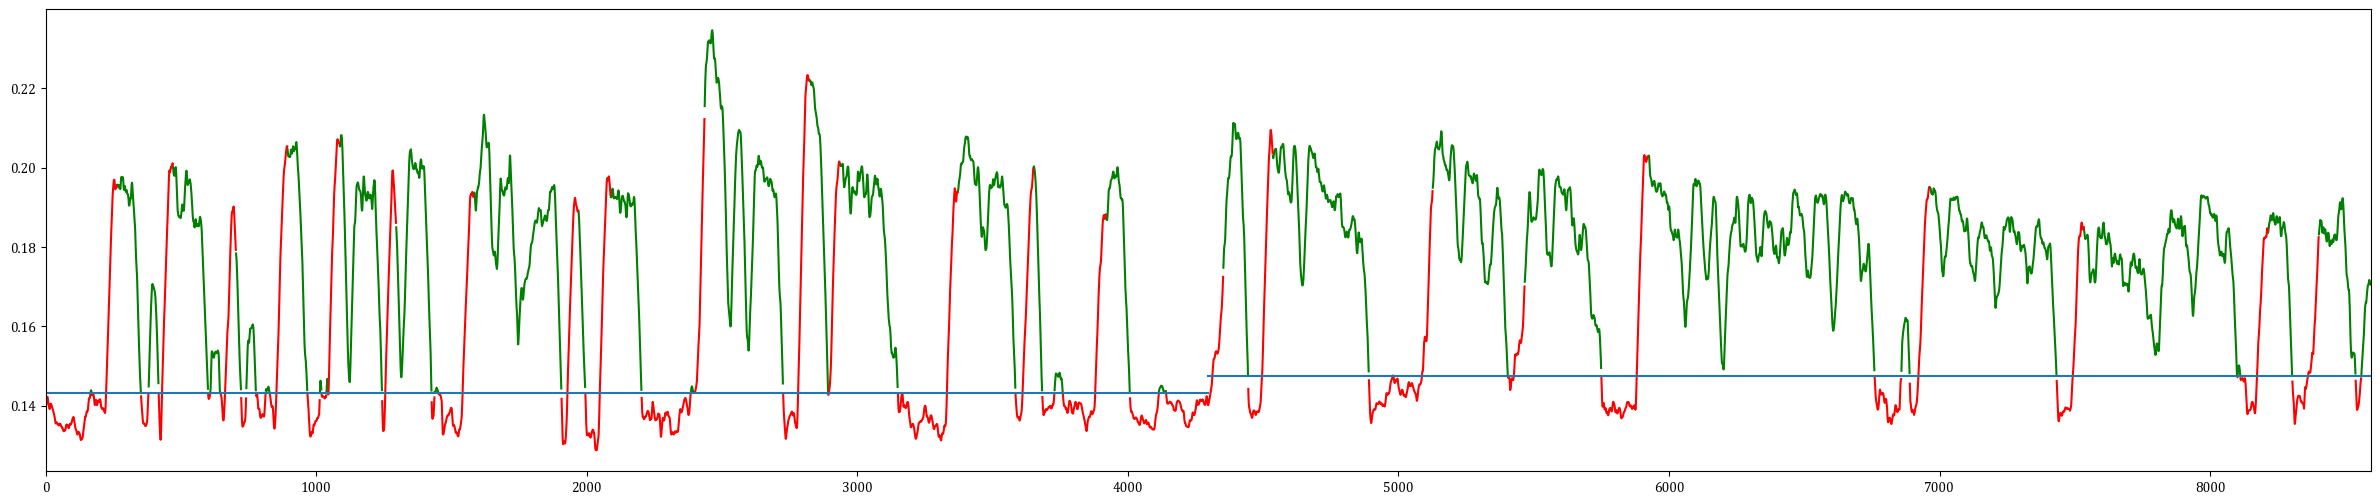

2248 wakes removed by threshold (ridges)
960 epochs removed after threshold intersection
3208 epochs removed in total by ridges


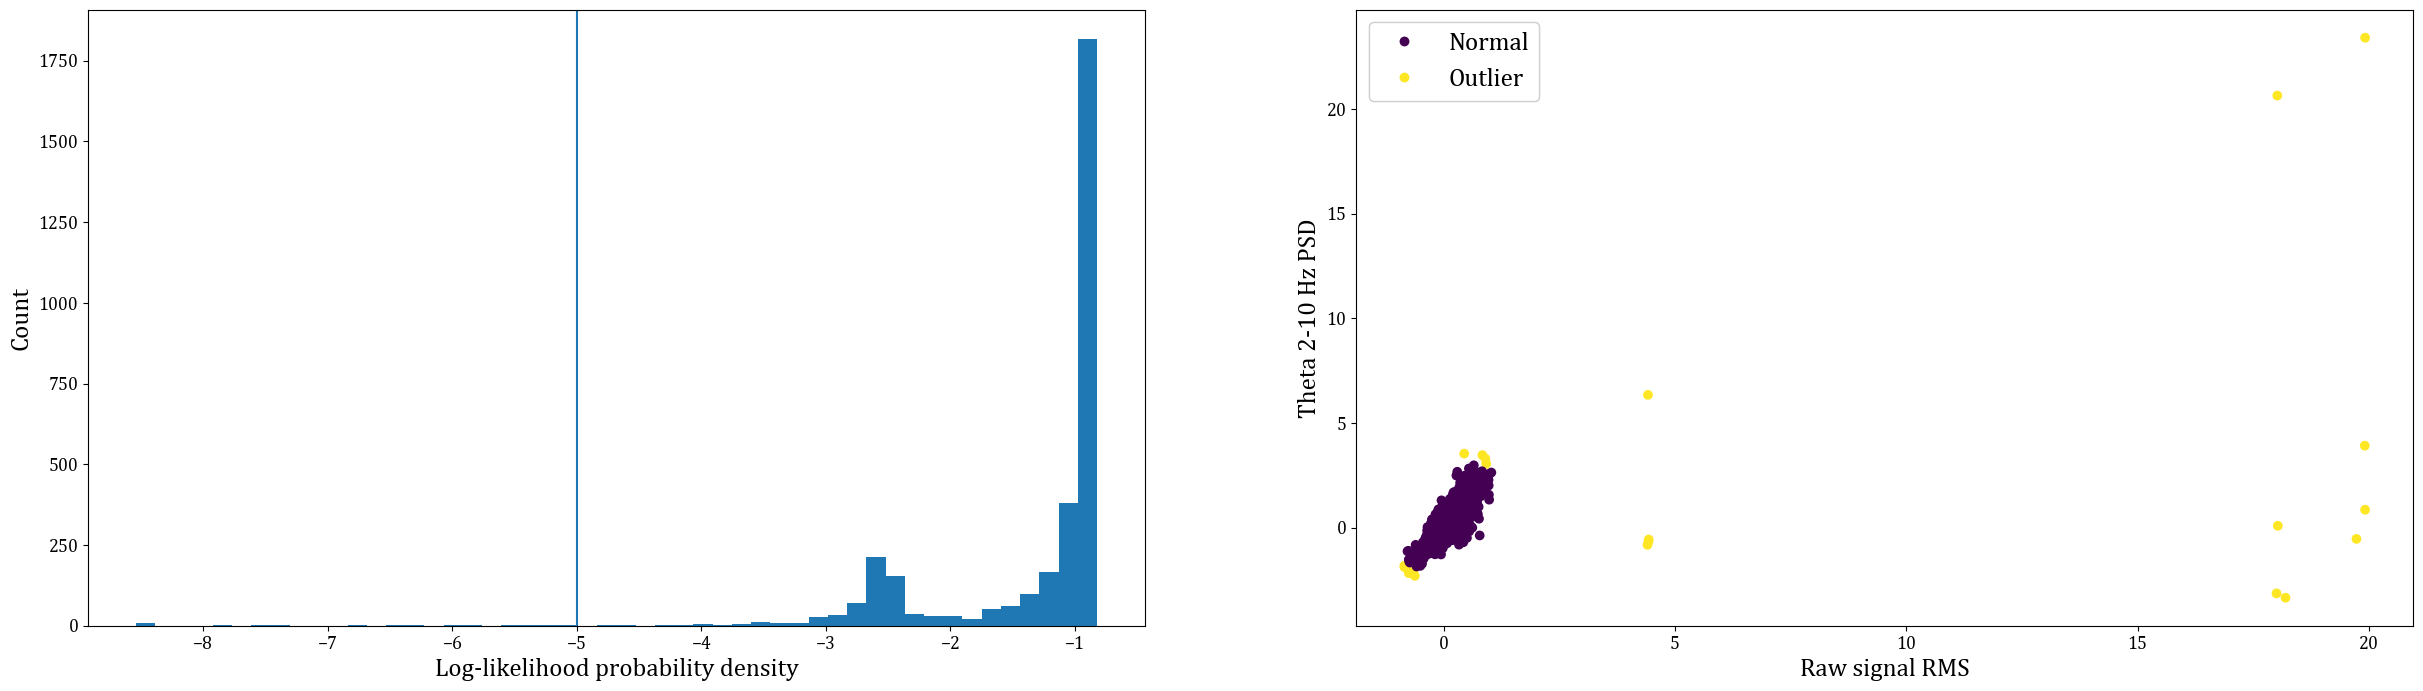

21 artefacts detected by Epanechnikov


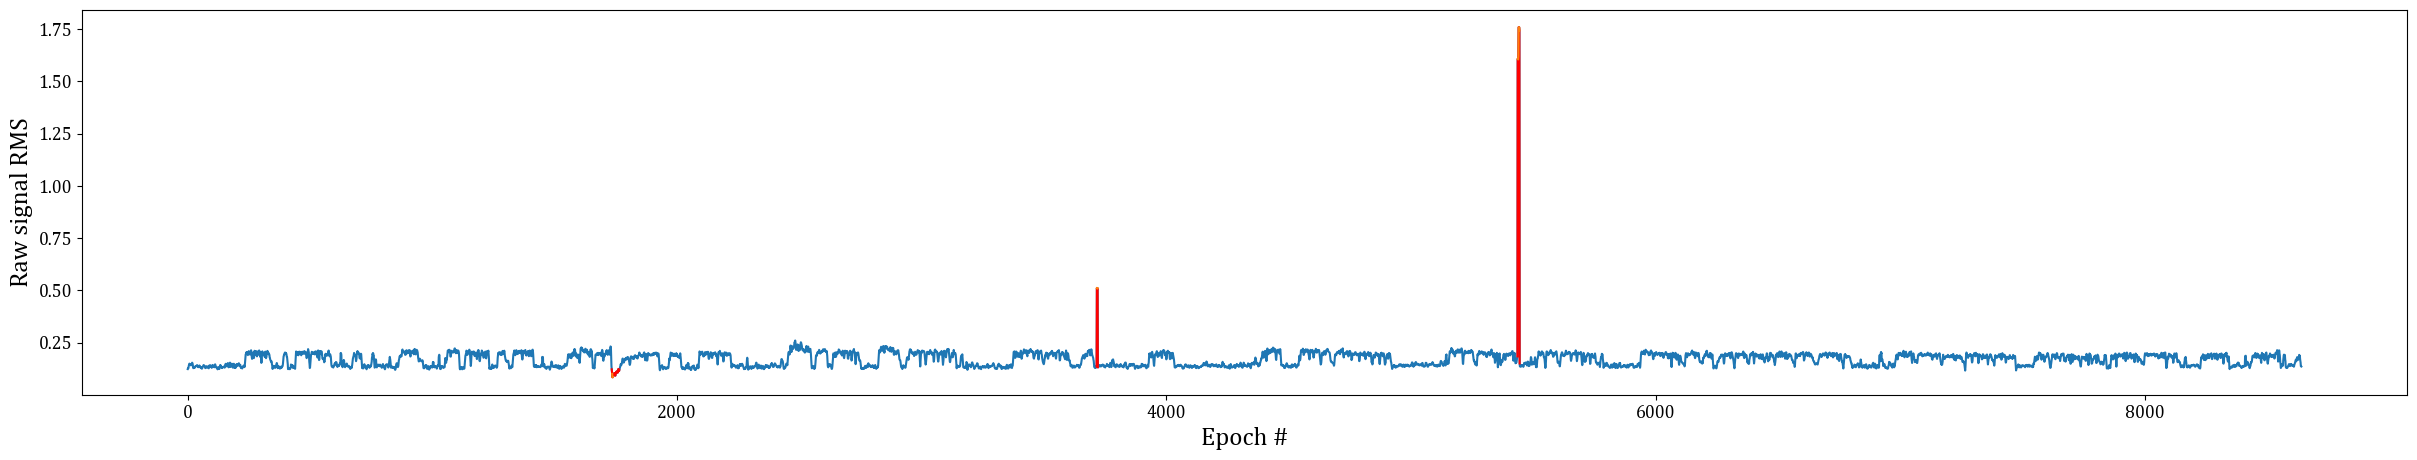

47 artefacts detected by thresholds


In [54]:
%matplotlib inline
force_art_thr = [False, False, False, (0.04, 0.14), (0.04, 0.14), (0.04, 0.12), (0.04, 0.12), (0.04, 0.12), (0.04, 0.14), (0.04, 0.15)] # !!!! ПО КОЛИЧЕСТВУ ЖИВОТНЫХ

w_humps = 150 # окно сглаживания горбов для порогов
w_humps_rises = 100 # окно сглаживания для выбрасывания восходящих сегментов
rise_len_thr = 40 # минимальная длина восходящего участка для выбрасывания
zbefore, oafter = 1, 40

ridge_thrs = [
#     None, # пороги вырезания горбов; просто None - стандартный режим с одним авто порогом
#     None,            # [None, None, None, None], # тоже авто пороги, но с разделением на равные куски по кол-ву None
#     None,
#     None,
#     None,
#     None,
#     None,
#     None,
    

    # [0.065],
    # [0.08],
    # [0.083],
    # [0.065],
    # [0.07],
    # [0.065],
    # [0.07],
    # [0.065], 
    
[None, None],
    [None, None], 
    [None, None],
    [0.065], 
    [None, None],
    [0.065], 
    [0.065],
    [None, None], 
    
    
#     [0.07, 0.065],
#     [0.07, 0.066],
#     [0.07, 0.065],
#     [0.07, 0.06],
#     [0.07, 0.065],
#     [0.07, 0.066],
#     [0.07, 0.065],
#     [0.07, 0.06], 
             ] # !!!! ПО КОЛИЧЕСТВУ ЖИВОТНЫХ. Для каждого животного столько значений, на столько равных частей со свои порогом и будут разбиты каждые сутки при вырезании горбов

Ep = [-5,
     -5,
     -5,
     -5,
     -5,
     -5,
     -3,
     -5] * 8 # epanechnikov по животным

verbose = 2
refined_ridges = None
fad = None
vote_dict, scorings = scorer_class.prescoring_artifacts(vote_dict, scorings, window_sec1=window_sec1, window_sec2=window_sec2, n_hours_cycle=n_hours_cycle, delta_cluster_bands=delta_cluster_bands, theta=theta, delta_mode=delta_mode, verbose=verbose, \
                                         theta_mode=theta_mode, filt_params=filt_params, pre_filt=pre_filt, depr=depr, spindles=spindles, cluster_strictness=w_nr_cluster_strictness, delta_ref_bands_red=delta_ref_bands_red, \
                                         theta_cluster_params=theta_cluster_params, red_mask=red_mask, n_back=1, w_nr_cluster_strictness=w_nr_cluster_strictness, smooth_fft=smooth_fft, w=w, cluster_artifact=cluster_artifact, \
                                        visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, parts=parts, force_art_thr=force_art_thr, w_humps=w_humps, save_pickle=save_pickle, skip_minutes=skip_minutes, ep=Ep, \
                                                        zbefore=zbefore, oafter=oafter, ridge_thrs=ridge_thrs, w_humps_rises=w_humps_rises, rise_len_thr=rise_len_thr, refined_ridges=refined_ridges, fad=fad)


### NREM-скоринг

In [55]:
vote_dict = scorer_class.prescoring_nrem(vote_dict, scorings, visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, verbose=verbose, fad=fad)

File "mouse_1.smr"
Animal 0



In [56]:
# здесь выбираем животное и номер дня для обрисовки области REM
fname = fnames[0] # файл для анализа
animal = 0
day = 0
fad = (fname, animal, day)

rough_separation = [False]*len(force_art_thr) # одно значение для каджого животного, и теперь тут не процент сдвига, а само значение порога; False - натуральное отделение 
                        
# поворот вертикального порога
theta_cluster_params['thr_angle'] = [[25]*(len(theta_cluster_params['ranges'])*len(deltas_for_rem)),# строка - все кластеры первого животного
                                    ] * len(rough_separation)
# сдвиг наклоненного порога в процентах от разброса данных по горизонтали; если с минусом, то сдвиг влево
theta_cluster_params['shift_thr_percent'] = [[0]*(len(theta_cluster_params['ranges'])*len(deltas_for_rem))# 1 строка - все кластеры первого животного
                                            ] * len(rough_separation)

show_plot = False

stringency = [len(delta_cluster_bands)/2] * len(rough_separation)# строгость для разделения по горизонтали. одно значение для каджого животного # сейчас не имеет значения
vote_dict_, scoring = scorer_class.prescoring_theta_comb(vote_dict, scoring, theta_cluster_params=theta_cluster_params, expert_hypnos=expert_hypnos, rough_separation=rough_separation, deltas_for_rem=deltas_for_rem, stringency=stringency, show_plot=show_plot, delta_theta_combs=delta_theta_combs, fad=fad)
vote_dict[fname][animal][day] = vote_dict_[fname][animal][day]

File "mouse_1.smr"
Animal 0
Day 0
Theta - (6, 10), delta - (2, 10)
Theta - (6, 9), delta - (2, 10)
Theta - (6, 9), delta - (2, 9)
Theta - (6, 10), delta - (2, 9)
Theta - (6, 10), delta - (2, 8)
Theta - (6, 10), delta - (2, 11)
Theta - (6, 9), delta - (2, 11)
Theta - (6, 9), delta - (2, 8)
Theta - (6, 9), delta - (2, 7)
Theta - (6, 10), delta - (2, 16)
Theta - (6, 10), delta - (2, 7)
Theta - (6, 9), delta - (3, 10)
Theta - (5, 9), delta - (2, 10)
Theta - (6, 10), delta - (2, 12)
Theta - (6, 10), delta - (3, 10)
Theta - (6, 10), delta - (2, 13)
Theta - (6, 10), delta - (2, 15)
Theta - (6, 10), delta - (2, 14)
Theta - (5, 10), delta - (2, 10)
Theta - (6, 10), delta - (3, 7)
Theta - (5, 9), delta - (2, 11)
Theta - (6, 9), delta - (2, 12)
Theta - (6, 9), delta - (2, 14)
Theta - (6, 10), delta - (3, 5)
Theta - (6, 9), delta - (2, 16)
Theta - (6, 10), delta - (2, 5)
Theta - (6, 9), delta - (2, 5)
Theta - (6, 10), delta - (2, 6)
Theta - (6, 9), delta - (2, 6)
Theta - (6, 9), delta - (2, 13)
30

In [57]:
to_ave_bcp, cl_nms_bcp, figsave_bcp = deepcopy(scorer_class.TO_AVE), list(scorer_class.CLUSTER_NAMES), deepcopy(scorer_class.FIGSAVE) # бэкап всех кластеров, выполнять стоит лишь однажды после их расчета в прошлой ячейке

In [58]:
mask_option = [[1]*(len(delta_theta_combs)) # theta_cluster_params)*len(deltas_for_rem
               # 1 строка - все кластера 1го животного; тут лучше все же четко соблюдать количество цифр по реальному количеству кластеров, а не с запасом
              ]* len(rough_separation)

single_nr = 2 # True значит, что удаляем
single_wake = False # True значит, что удаляем

single_nrem2_1_2 = True # True значит, что удаляем единичный NREM между двумя REMами
single_wake2_0_2 = True # True значит, что удаляем единичный Wake между двумя REMами

single_r = True # удаление REM единичной или любой другой длины (если > 1, то удаляются и все, что короче), True = 1, можно выключить с помощью False

# Правила ниже для конкретных ситуцаций с единичными РЕМами сейчас выключены, их заменяет общее правило по единичным РЕМам 
# single_rem1_2_0 = True # True значит, что удаляем
# single_rem1_2_1 = True # True значит, что удаляем

In [59]:
# обводка
selection = None # в первый раз None, поэтому делаем обводку
ellipse_magnify = 1.8 # увеличение эллипса автоматической обводки
manual_contour = True # ручной режим обводки (True) или автоматический эллипс (False)

n_back = 20 # сколько проверяем прошлых эпох перед REM на предмет бодрствования
wake_thr = 5# сколько прошлых эпох должны быть бодрствованием, чтобы текущую точно нельзя было признать быстрым сном
clear_start_rem = True # отдельно вычищать REM после Wake в самом начале гипнограммы
n_back_old = 2 # старый n_back (удаляем эпизод РЕМ, если перед ним было n_back_old подряд штук вейков)
cut_left = False # Вырезать ли для второго прогона серые пунктиры слева от REM

rule = [30] * len(vote_dict[fname])

verbose = 1
scoring = scorings[fname][animal][day]
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
hypno_labels.setdefault(fname, {})
last_hypnos.setdefault(fname, {})
hypno_labels[fname].setdefault(animal, {})
last_hypnos[fname].setdefault(animal, {})
hypno_labels[fname][animal].setdefault(day, {})
last_hypnos[fname][animal].setdefault(day, {})
(img, selection), hypno_labels[fname][animal][day], last_hypnos[fname][animal][day] = scorer_class.end_scoring_selection(vote_dict, fname, animal, day, fnames, scoring, rule, cluster_artifact, 1, red_mask, expert_hypnos, mask_option, single_nr, single_wake,
                                                                                      None, None, n_hours_cycle_rem, verbose, save_dir=save_dir, spindles=None, ep=Ep, manual_contour=manual_contour, vote_pass=np.arange(len(delta_theta_combs)), ellipse_magnify=ellipse_magnify, selection=selection) # single_rem1_2_0, single_rem1_2_1
img

Animal 0
Day 0
len(to_vote) = 30
voting using 30 clusters. rule = 30
20 2-long or shorter NREM epochs corrected
Wake - 770; NREM - 4135; REM - 480; 


:Scatter   [Theta]   (~Delta,state)

In [73]:
# сохранение результата после каждой обводки
bcp_hl = np.array(hypno_labels[fname][animal][day])
if manual_contour: 
    print(f'{np.where(hypno_labels[fname][animal][day][selection.index] != 2)[0].size} points forced to REM')
    hypno_labels[fname][animal][day][selection.index] = 2 # Holoviews manual selection
    selection_transfer = np.zeros(len(scoring.nr_mask))
    nr_sel = selection_transfer[scoring.nr_mask]
    nr_sel[selection.index] = 1
    selection_transfer[scoring.nr_mask] = nr_sel
else: 
    print(f'{np.where(hypno_labels[fname][animal][day][selection] != 2)[0].size} points forced to REM')
    hypno_labels[fname][animal][day][selection] = 2

46 points forced to REM


In [89]:
# ## При необходимости делаем обратную коррекцию излишне обрисованного REMa
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
av_clust = np.hstack((np.vstack([el[0].reshape((1, -1)) for el in scorer_class.TO_AVE[fname][animal][day]]).mean(axis=0)[:, None], np.vstack([el[1].reshape((1, -1)) for el in scorer_class.TO_AVE[fname][animal][day]]).mean(axis=0)[:, None]))

hypl = np.array(hypno_labels[fname][animal][day]).reshape((-1, 1))

df = pd.DataFrame(np.hstack((av_clust, hypl)), columns=('Theta', '~Delta', 'state'))
img, selection2 = scorer_class.sel_scatter(df, True)
img

:Scatter   [Theta]   (~Delta,state)

In [90]:
# применение изменений обратной отрисовки (если не делали, пропустите этот блок)
relabel = scorer_class.nearest_w_nr(selection2, df)
hypno_labels[fname][animal][day][selection2.index] = relabel[:, None]

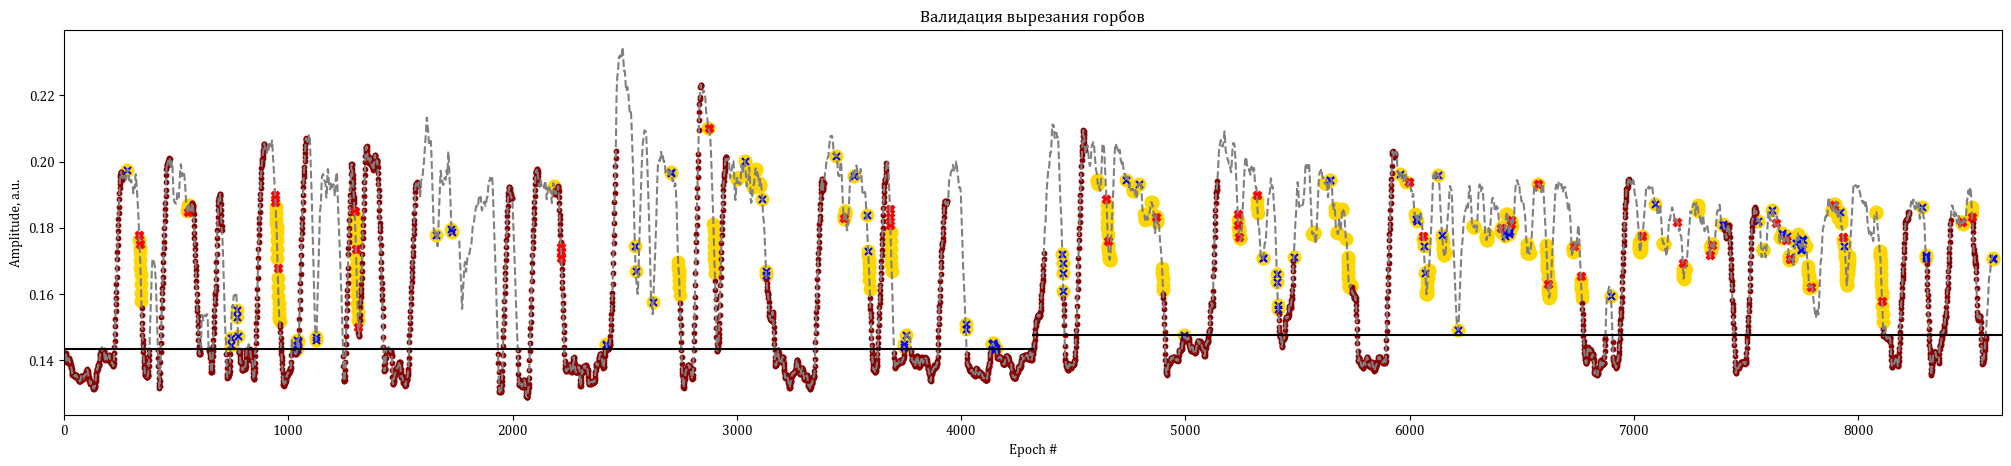

Before contextual rules:
General accuracy = 0.93
Balanced accuracy = 0.92
General Cohen's kappa = 0.87
F1 = 0.93
Confusion matrix:
[[3089  262   56]
 [ 216 4503   46]
 [  24   24  420]]
Accuracies by class: 0.91, 0.95, 0.90
Sensitivities by class: 0.91 0.95 0.90
Specificities by class: 0.95 0.93 0.99
Cohen's kappas by class: 0.86 0.87 0.84
F1 by class: 0.92 0.94 0.85
0 REMs turned to Wake in the very beginning
36 REMs turned to Wake by analyzing preceding states
0 single NREMs between REMs and REMs corrected
18 single Wakes between REMs and REMs corrected
24 1-long or shorter REM epochs corrected


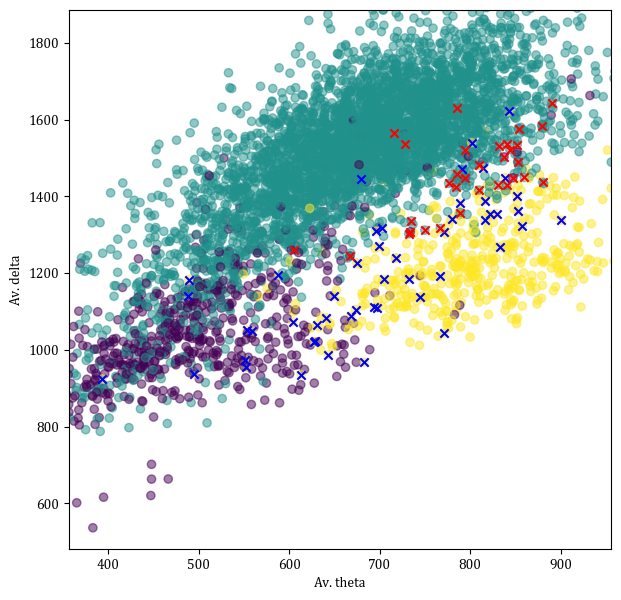

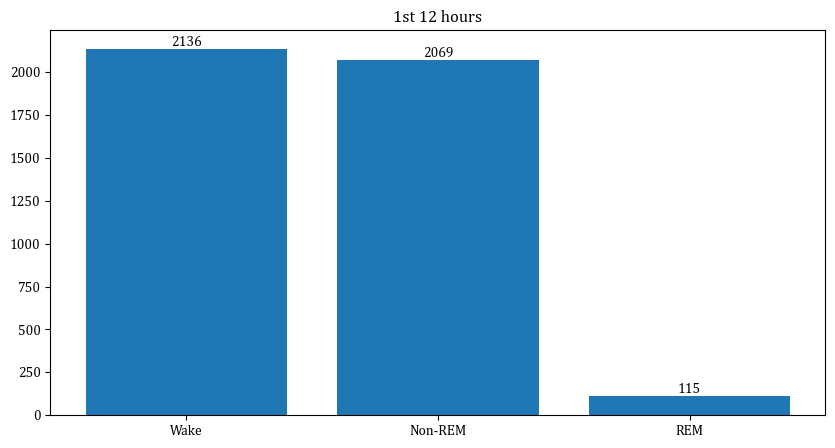

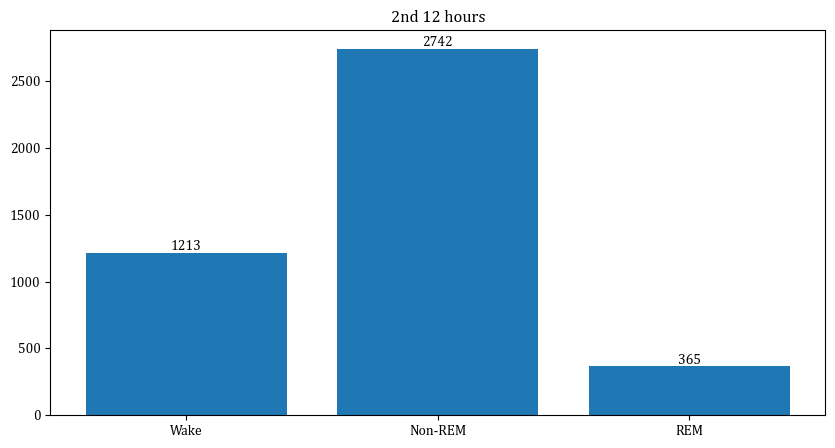

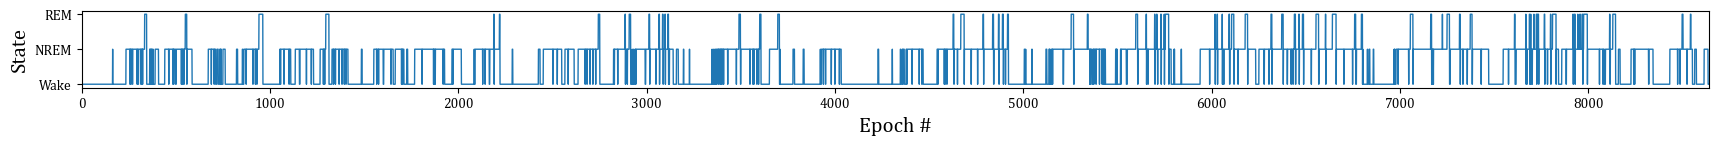

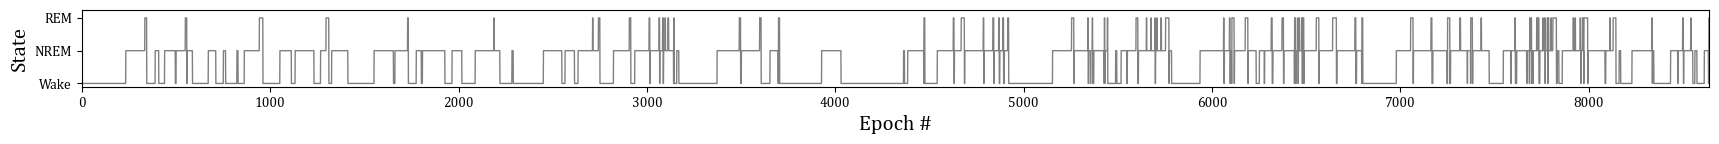

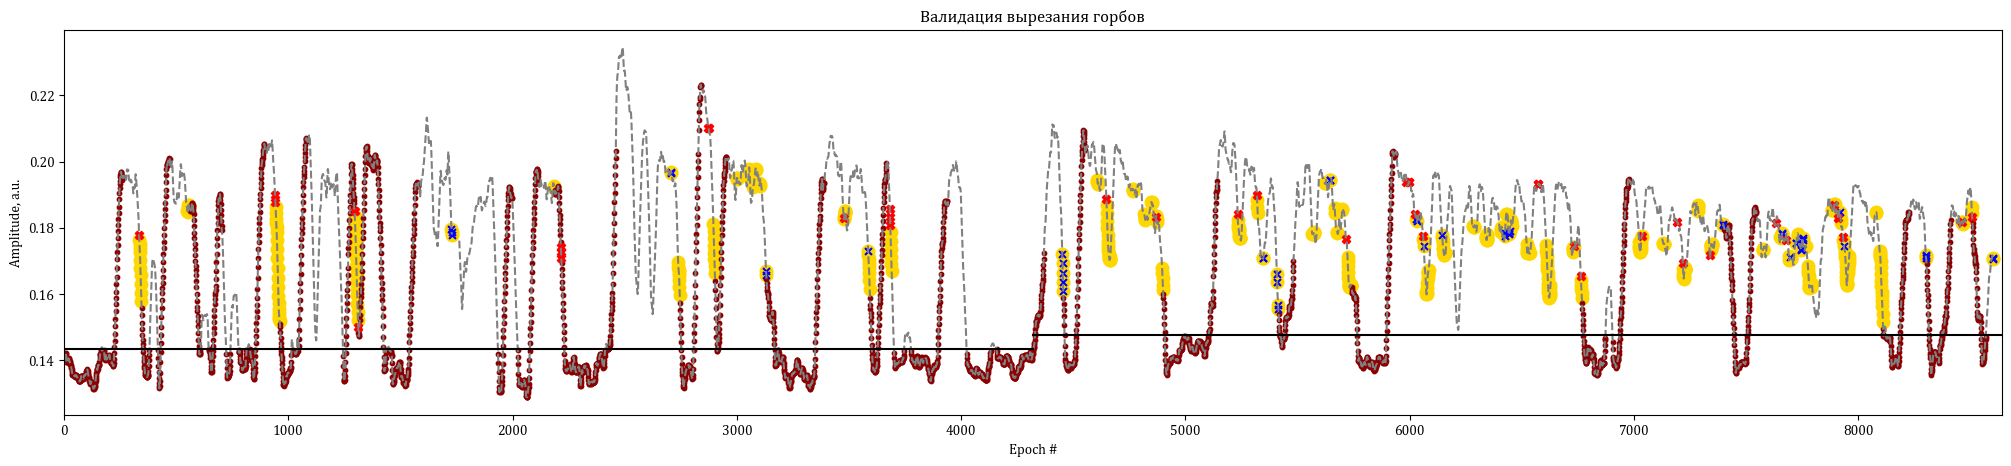

221 more points will be removed between detected REM and ridge-removed points
General accuracy = 0.93
Balanced accuracy = 0.93
General Cohen's kappa = 0.88
F1 = 0.93
Confusion matrix:
[[3125  262   20]
 [ 215 4519   31]
 [   9   30  429]]
Accuracies by class: 0.92, 0.95, 0.92
Sensitivities by class: 0.92 0.95 0.92
Specificities by class: 0.96 0.92 0.99
Cohen's kappas by class: 0.88 0.87 0.90
F1 by class: 0.93 0.94 0.91


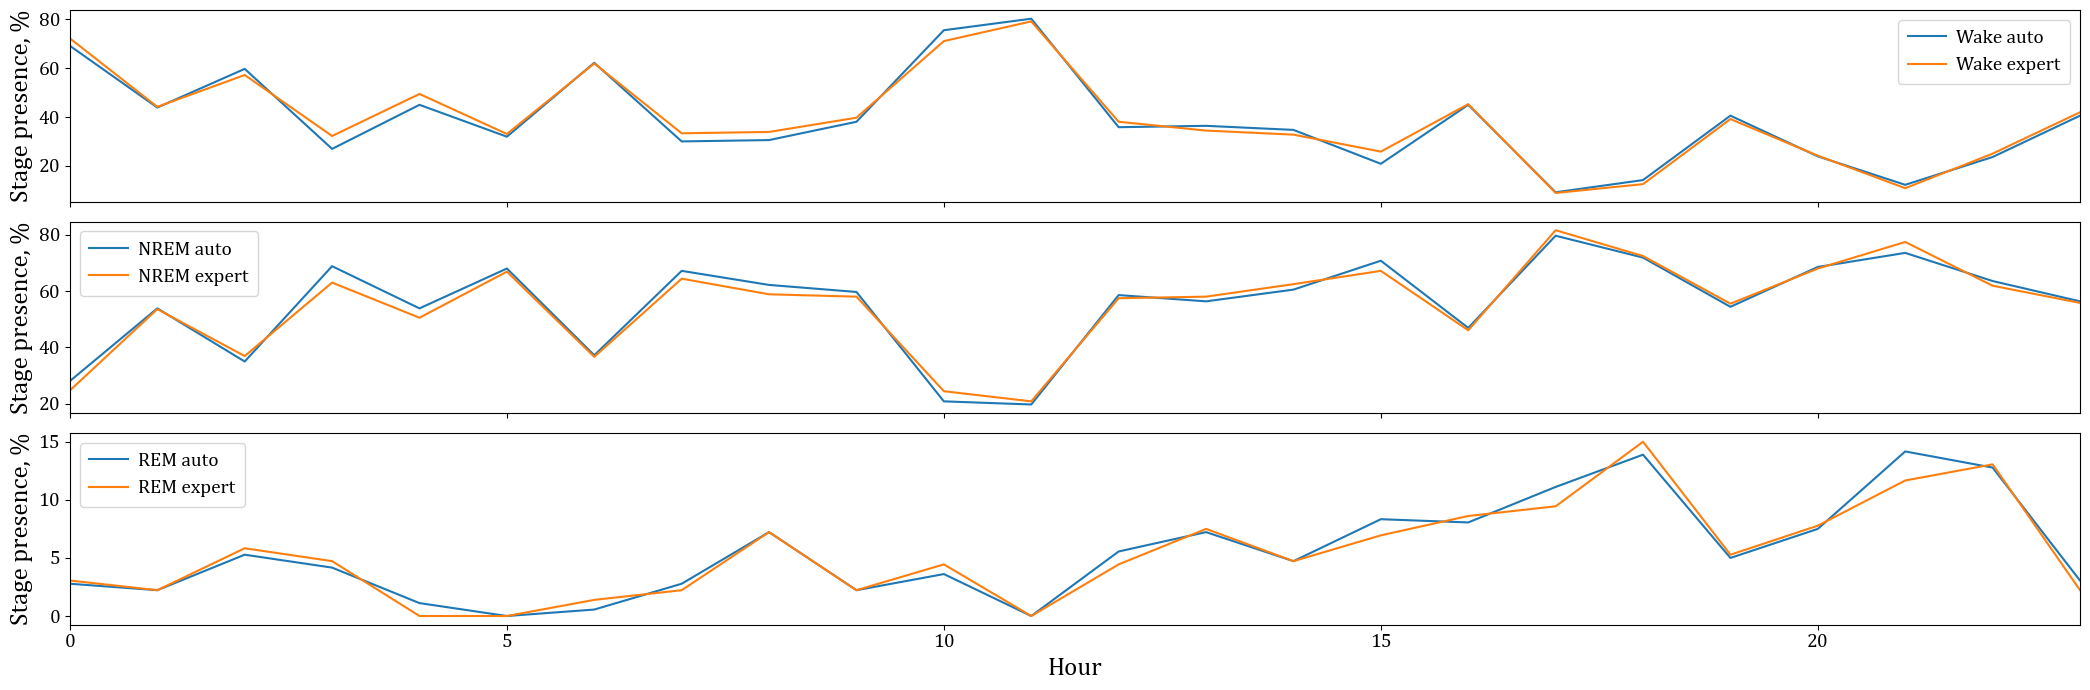

In [74]:
# окончание скоринга текущего животного
verbose = 2
rnr_edges = 2 # Либо False, либо число эпох на границе REM-NR, которые надо обвести черным на усредненом кластере
# save_spec_params = {'ranges': [(1, 4), (5, 8), (11, 16), (17, 25), (36, 58)], 'window_sec': 3600} # окно в секундах (1, 4), (5, 8)
save_spec_params = {'ranges': [], 'window_sec': 3600} #(1, 4), (5, 8), (11, 16), (17, 35), (36, 58) окно в секундах (1, 4), (5, 8)

scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
fracs.setdefault(fname, {})
fragms.setdefault(fname, {})
hypnos.setdefault(fname, {})
saved_specs.setdefault(fname, {})
fracs[fname].setdefault(animal, {})
fragms[fname].setdefault(animal, {})
hypnos[fname].setdefault(animal, {})
saved_specs[fname].setdefault(animal, {})
scorer_class.FIGSAVE = figsave_bcp
to_interactive, frac_, fragm_, hypn_, sasp_, refined_ridges = scorer_class.end_scoring_final(vote_dict, fnames, scoring, n_hours_cycle_bars, minutes, hours_fragm, red_mask, n_hours_cycle_rem, expert_hypnos, verbose, hypno_labels, last_hypnos, 
                                                                             n_back, wake_thr, single_nrem2_1_2, single_wake2_0_2, single_r, n_back_old,
                        save_spec_params=save_spec_params, spindles=None, spec_max= [[None] * len(save_spec_params['ranges'])] * 8, get_particular=(fname, animal, day), save_dir=save_dir, clear_start_rem=clear_start_rem, cut_left=cut_left, rnr_edges=rnr_edges)
fracs[fname][animal][day], fragms[fname][animal][day], hypnos[fname][animal][day], saved_specs[fname][animal][day] = frac_[fname], fragm_[fname], hypn_[fname][0], sasp_[fname][animal][0]
figsave_bcp = deepcopy(scorer_class.FIGSAVE)


## Второй прогон с уточненным вырезанием горбов

In [63]:
%matplotlib inline
verbose = 0
vote_dict_, scorings_ = scorer_class.prescoring_artifacts(vote_dict, scorings, window_sec1=window_sec1, window_sec2=window_sec2, n_hours_cycle=n_hours_cycle, delta_cluster_bands=delta_cluster_bands, theta=theta, delta_mode=delta_mode, verbose=verbose, \
                                         theta_mode=theta_mode, filt_params=filt_params, pre_filt=pre_filt, depr=depr, spindles=spindles, cluster_strictness=w_nr_cluster_strictness, delta_ref_bands_red=delta_ref_bands_red, \
                                         theta_cluster_params=theta_cluster_params, red_mask=red_mask, n_back=1, w_nr_cluster_strictness=w_nr_cluster_strictness, smooth_fft=smooth_fft, w=w, cluster_artifact=cluster_artifact, \
                                        visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, parts=parts, force_art_thr=force_art_thr, w_humps=w_humps, save_pickle=save_pickle, skip_minutes=skip_minutes, ep=Ep, \
                                                        zbefore=zbefore, oafter=oafter, ridge_thrs=ridge_thrs, w_humps_rises=w_humps_rises, rise_len_thr=rise_len_thr, refined_ridges=refined_ridges, fad=fad)
vote_dict[fname][animal][day] = vote_dict_[fname][animal][day]
scorings[fname][animal][day] = scorings_[fname][animal][day]

File "mouse_1.smr"
Animal 0
20 artefacts detected by Epanechnikov
16 artefacts detected by thresholds


In [64]:
vote_dict_ = scorer_class.prescoring_nrem(vote_dict, scorings, visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, verbose=verbose, fad=fad)
vote_dict[fname][animal][day] = vote_dict_[fname][animal][day]

File "mouse_1.smr"
Animal 0



In [65]:
vote_dict, scoring = scorer_class.prescoring_theta_comb(vote_dict, scoring, theta_cluster_params=theta_cluster_params, expert_hypnos=expert_hypnos, rough_separation=rough_separation, deltas_for_rem=deltas_for_rem, stringency=stringency, show_plot=show_plot, delta_theta_combs=delta_theta_combs, fad=fad)
vote_dict[fname][animal][day] = vote_dict_[fname][animal][day]
scorings[fname][animal][day] = scorings_[fname][animal][day]

File "mouse_1.smr"
Animal 0
Day 0
Theta - (6, 10), delta - (2, 10)
Theta - (6, 9), delta - (2, 10)
Theta - (6, 9), delta - (2, 9)
Theta - (6, 10), delta - (2, 9)
Theta - (6, 10), delta - (2, 8)
Theta - (6, 10), delta - (2, 11)
Theta - (6, 9), delta - (2, 11)
Theta - (6, 9), delta - (2, 8)
Theta - (6, 9), delta - (2, 7)
Theta - (6, 10), delta - (2, 16)
Theta - (6, 10), delta - (2, 7)
Theta - (6, 9), delta - (3, 10)
Theta - (5, 9), delta - (2, 10)
Theta - (6, 10), delta - (2, 12)
Theta - (6, 10), delta - (3, 10)
Theta - (6, 10), delta - (2, 13)
Theta - (6, 10), delta - (2, 15)
Theta - (6, 10), delta - (2, 14)
Theta - (5, 10), delta - (2, 10)
Theta - (6, 10), delta - (3, 7)
Theta - (5, 9), delta - (2, 11)
Theta - (6, 9), delta - (2, 12)
Theta - (6, 9), delta - (2, 14)
Theta - (6, 10), delta - (3, 5)
Theta - (6, 9), delta - (2, 16)
Theta - (6, 10), delta - (2, 5)
Theta - (6, 9), delta - (2, 5)
Theta - (6, 10), delta - (2, 6)
Theta - (6, 9), delta - (2, 6)
Theta - (6, 9), delta - (2, 13)
30

In [66]:
to_ave_bcp, cl_nms_bcp, figsave_bcp = deepcopy(scorer_class.TO_AVE), list(scorer_class.CLUSTER_NAMES), deepcopy(scorer_class.FIGSAVE) # бэкап всех кластеров, выполнять стоит лишь однажды после их расчета в прошлой ячейке

In [69]:
print(selection.index)

[77, 78, 79, 80, 81, 82, 83, 84, 209, 211, 213, 214, 215, 216, 317, 349, 415, 416, 417, 418, 419, 420, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431, 432, 433, 446, 448, 491, 612, 614, 615, 616, 618, 619, 620, 621, 622, 623, 624, 625, 626, 835, 903, 1174, 1222, 1313, 1395, 1475, 1476, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1637, 1638, 1639, 1689, 1690, 1709, 1710, 1721, 1736, 1739, 1750, 1767, 1859, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1938, 2003, 2004, 2005, 2006, 2007, 2008, 2036, 2038, 2039, 2040, 2058, 2165, 2166, 2176, 2177, 2178, 2179, 2184, 2185, 2186, 2188, 2192, 2195, 2277, 2278, 2279, 2281, 2285, 2287, 2342, 2343, 2344, 2345, 2384, 2385, 2386, 2387, 2388, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2501, 2502, 2503, 2552, 2553, 2554, 2555, 2556, 2583, 2584, 2585, 2605, 2606, 2607, 2608, 2631, 2632, 2633, 2634, 2635, 2643, 2737, 2739, 2740, 2741, 2742, 2743, 2745, 2746, 2747, 2748, 2824, 2825, 284

In [68]:
maxnr = np.argwhere(scoring.nr_mask).size
sel_ = np.array([ids if ids < maxnr else None for ids in np.argwhere(selection_transfer[scoring.nr_mask] == 1)])
sel_ = sel_[~np.isnan(sel_)]
sel_

array([  77,   78,   79,   80,   81,   82,   83,   84,  201,  203,  205,
        206,  207,  208,  266,  298,  364,  365,  366,  367,  368,  369,
        370,  371,  372,  374,  375,  376,  377,  378,  379,  380,  381,
        382,  390,  392,  435,  556,  558,  559,  560,  562,  563,  564,
        565,  566,  567,  568,  569,  570,  664,  732, 1034, 1038, 1130,
       1212, 1292, 1293, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330,
       1388, 1389, 1390, 1391, 1392, 1393, 1394, 1441, 1442, 1443, 1493,
       1494, 1513, 1514, 1525, 1540, 1543, 1554, 1571, 1627, 1661, 1662,
       1663, 1664, 1665, 1666, 1667, 1706, 1771, 1772, 1773, 1774, 1775,
       1776, 1795, 1797, 1798, 1799, 1817, 1924, 1925, 1935, 1936, 1937,
       1938, 1943, 1944, 1945, 1947, 1951, 1954, 2036, 2037, 2038, 2040,
       2095, 2096, 2097, 2098, 2137, 2138, 2139, 2140, 2141, 2143, 2144,
       2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2254, 2255,
       2256, 2305, 2306, 2307, 2308, 2309, 2336, 23

In [71]:
for i in range(len(selection.index)): del selection.index[0]
for el in sel_: selection.index.append(el)

In [72]:
# обводка
ellipse_mahnify = 1.8
n_back_old = False
# manual_contour = False # ручной режим обводки (True) или автоматический эллипс (False)

verbose = 1
scoring = scorings[fname][animal][day]
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
hypno_labels.setdefault(fname, {})
last_hypnos.setdefault(fname, {})
hypno_labels[fname].setdefault(animal, {})
last_hypnos[fname].setdefault(animal, {})
hypno_labels[fname][animal].setdefault(day, {})
last_hypnos[fname][animal].setdefault(day, {})
(img, selection_), hypno_labels[fname][animal][day], last_hypnos[fname][animal][day] = scorer_class.end_scoring_selection(vote_dict, fname, animal, day, fnames, scoring, rule, cluster_artifact, 1, red_mask, expert_hypnos, mask_option, single_nr, single_wake,
                                                                                      None, None, n_hours_cycle_rem, verbose, save_dir=save_dir, spindles=None, ep=Ep, manual_contour=manual_contour, vote_pass=np.arange(len(delta_theta_combs)), ellipse_magnify=ellipse_magnify, selection=selection) # single_rem1_2_0, single_rem1_2_1
img

Animal 0
Day 0
len(to_vote) = 30
voting using 30 clusters. rule = 30
16 2-long or shorter NREM epochs corrected
Wake - 619; NREM - 3895; REM - 476; 


:Overlay
   .Scatter.I  :Scatter   [Theta]   (~Delta,state)
   .Polygons.I :Polygons   [x,y]

In [65]:
# сохранение результата после каждой обводки
bcp_hl = np.array(hypno_labels[fname][animal][day])
if manual_contour:
    if len(selection_.index) != 0: selection = selection_
    else: selection = scorer_class.correct_selection(selection, scoring)
    print(f'{np.where(hypno_labels[fname][animal][day][selection.index] != 2)[0].size} points forced to REM')
    hypno_labels[fname][animal][day][selection.index] = 2 # Holoviews manual selection
    
else: 
    print(f'{np.where(hypno_labels[fname][animal][day][selection] != 2)[0].size} points forced to REM')
    hypno_labels[fname][animal][day][selection] = 2

82 points forced to REM


In [89]:
# ## При необходимости делаем обратную коррекцию излишне обрисованного REMa
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
av_clust = np.hstack((np.vstack([el[0].reshape((1, -1)) for el in scorer_class.TO_AVE[fname][animal][day]]).mean(axis=0)[:, None], np.vstack([el[1].reshape((1, -1)) for el in scorer_class.TO_AVE[fname][animal][day]]).mean(axis=0)[:, None]))

hypl = np.array(hypno_labels[fname][animal][day]).reshape((-1, 1))

df = pd.DataFrame(np.hstack((av_clust, hypl)), columns=('Theta', '~Delta', 'state'))
img, selection2 = scorer_class.sel_scatter(df, True)
img

:Scatter   [Theta]   (~Delta,state)

In [90]:
# применение изменений обратной отрисовки (если не делали, пропустите этот блок)
relabel = scorer_class.nearest_w_nr(selection2, df)
hypno_labels[fname][animal][day][selection2.index] = relabel[:, None]

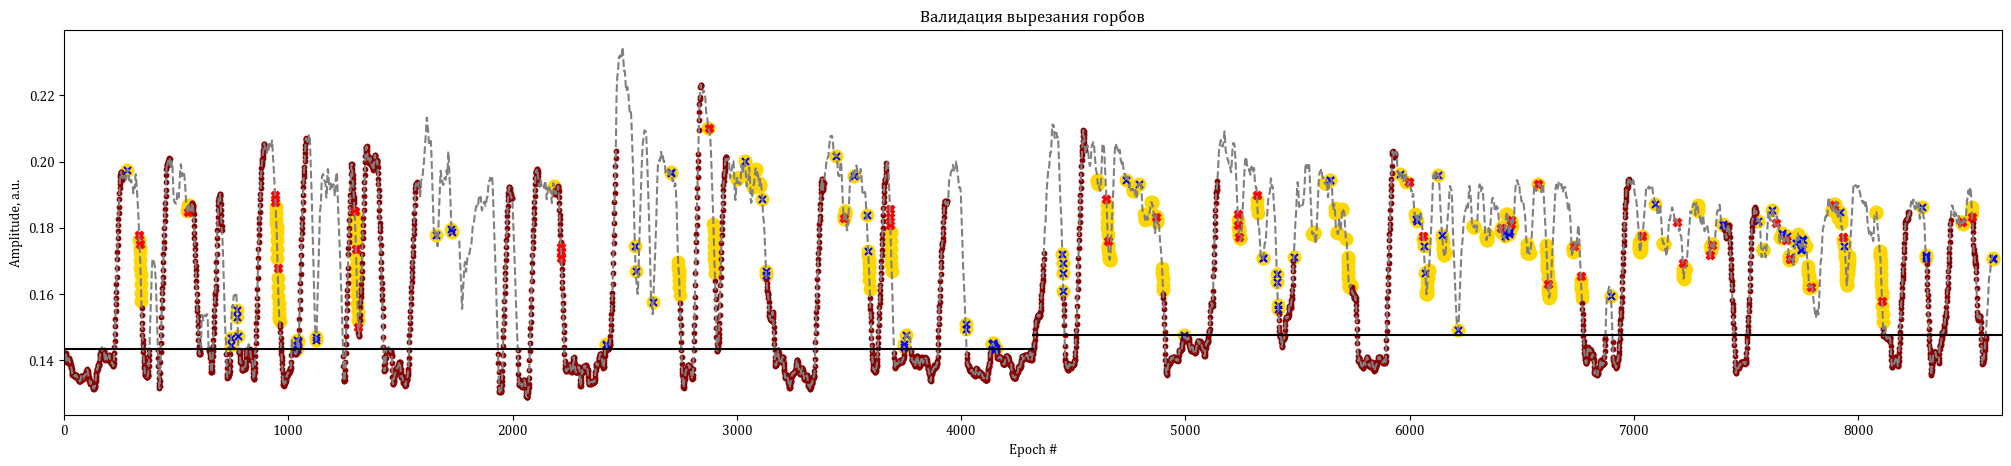

Before contextual rules:
General accuracy = 0.93
Balanced accuracy = 0.92
General Cohen's kappa = 0.87
F1 = 0.93
Confusion matrix:
[[3089  262   56]
 [ 216 4503   46]
 [  24   24  420]]
Accuracies by class: 0.91, 0.95, 0.90
Sensitivities by class: 0.91 0.95 0.90
Specificities by class: 0.95 0.93 0.99
Cohen's kappas by class: 0.86 0.87 0.84
F1 by class: 0.92 0.94 0.85
0 REMs turned to Wake in the very beginning
36 REMs turned to Wake by analyzing preceding states
0 single NREMs between REMs and REMs corrected
18 single Wakes between REMs and REMs corrected
24 1-long or shorter REM epochs corrected


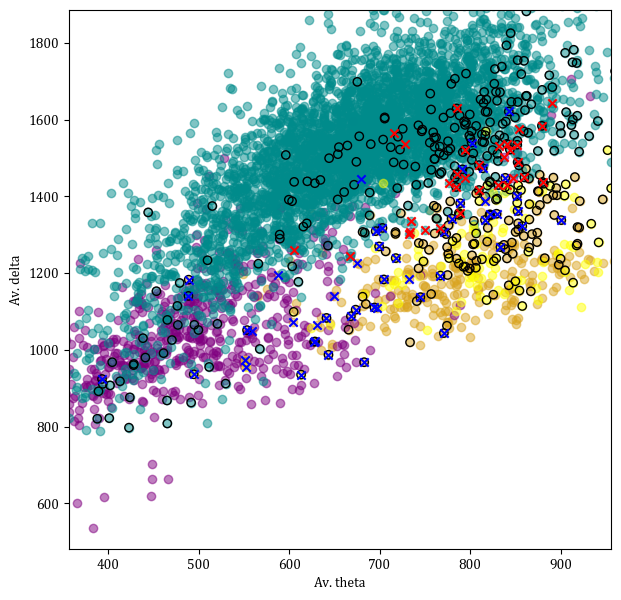

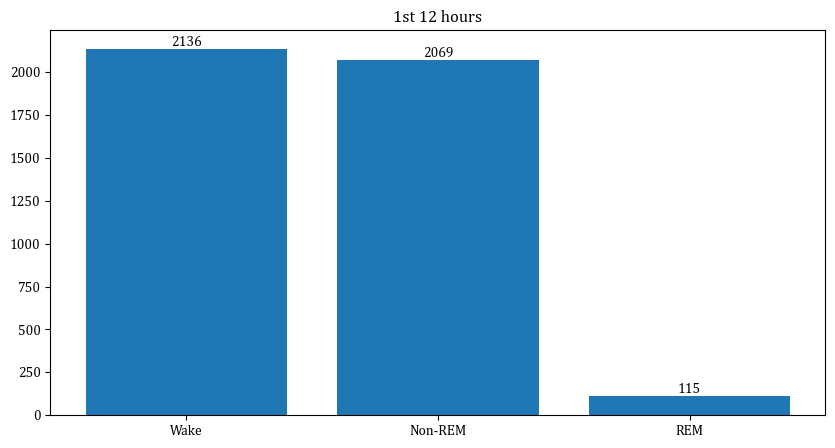

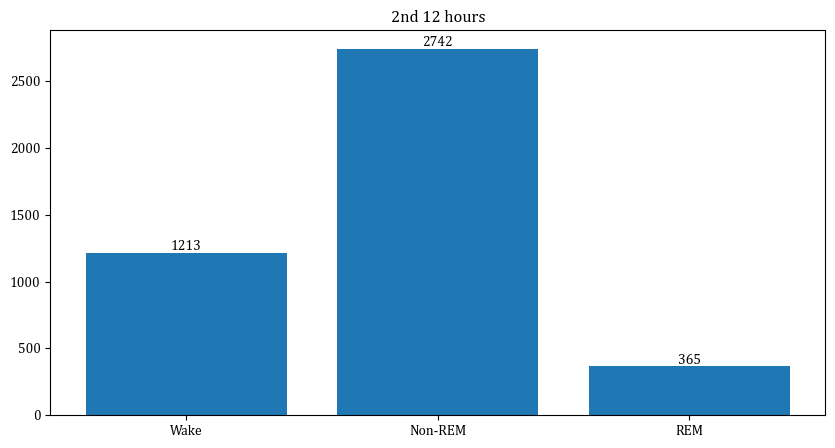

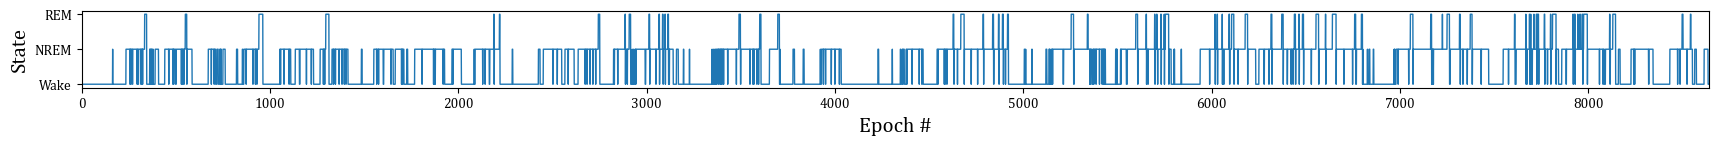

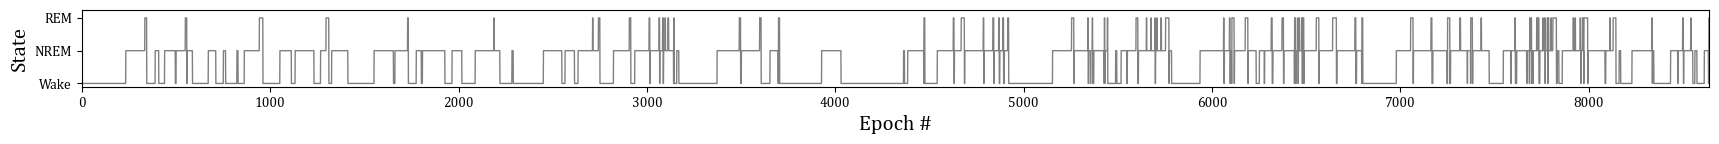

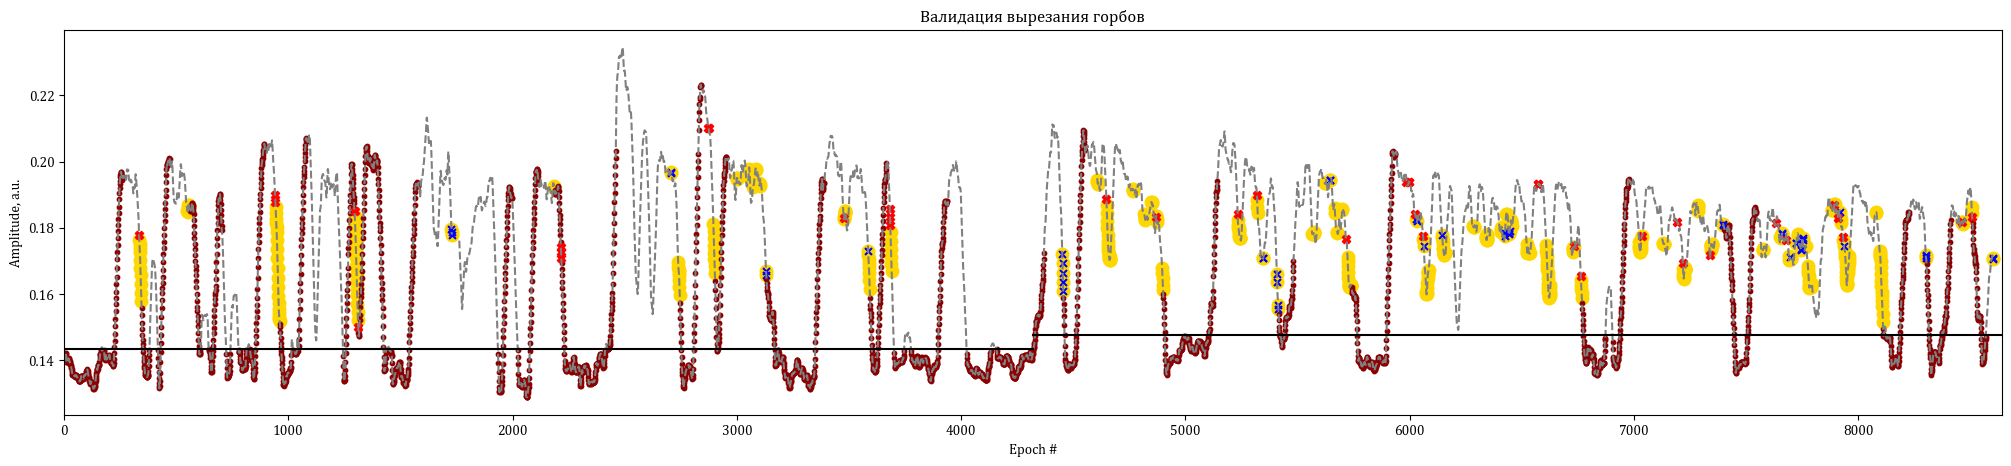

221 more points will be removed between detected REM and ridge-removed points
General accuracy = 0.93
Balanced accuracy = 0.93
General Cohen's kappa = 0.88
F1 = 0.93
Confusion matrix:
[[3125  262   20]
 [ 215 4519   31]
 [   9   30  429]]
Accuracies by class: 0.92, 0.95, 0.92
Sensitivities by class: 0.92 0.95 0.92
Specificities by class: 0.96 0.92 0.99
Cohen's kappas by class: 0.88 0.87 0.90
F1 by class: 0.93 0.94 0.91


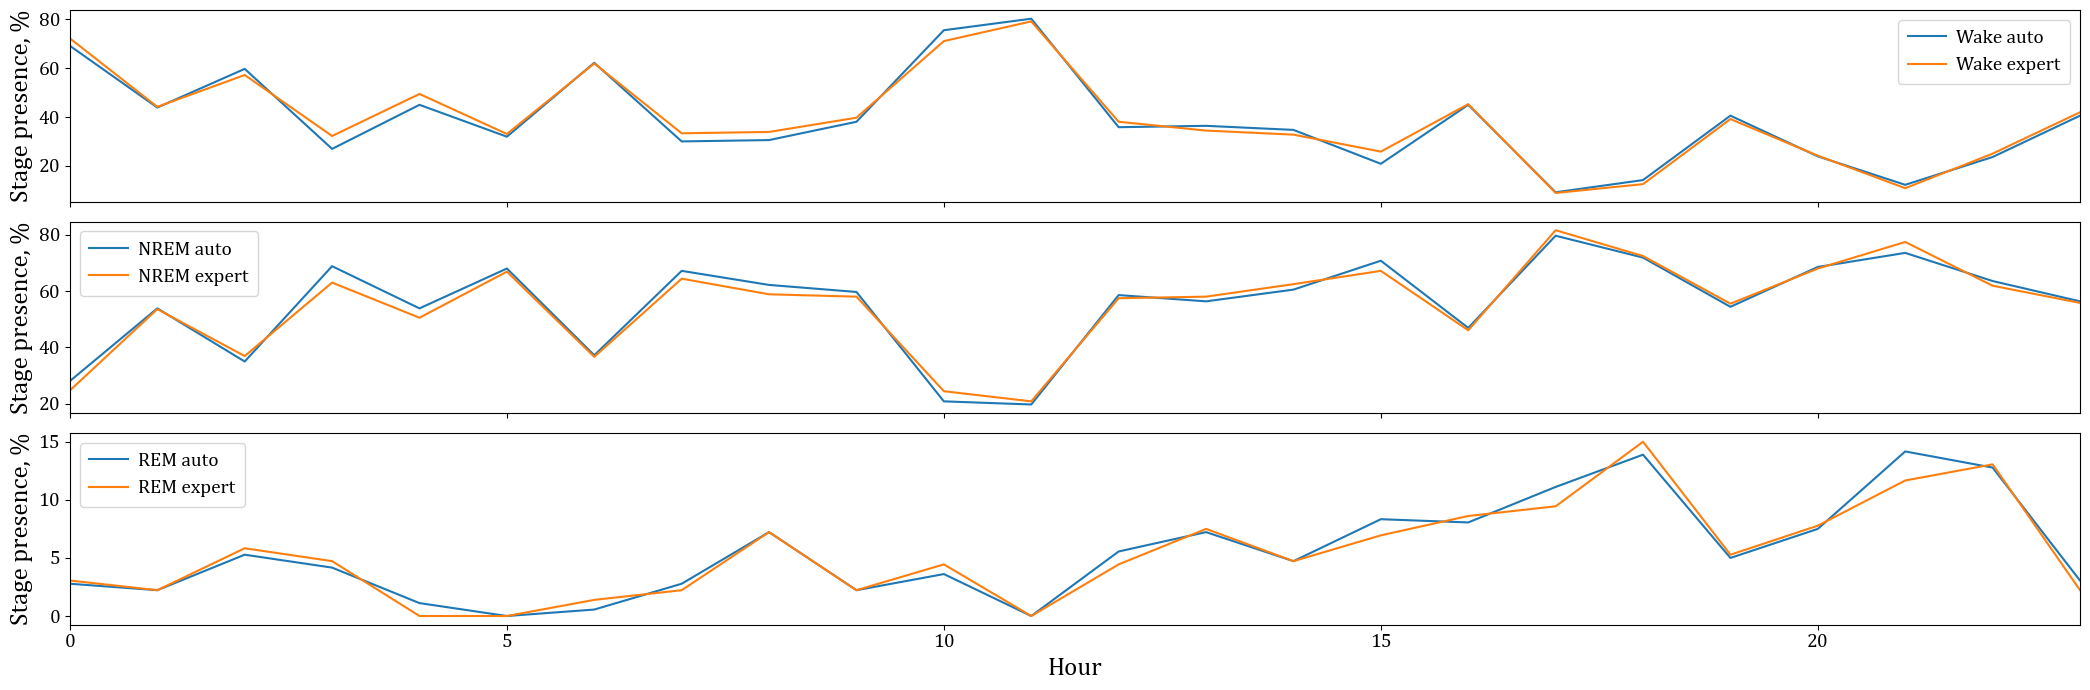

In [84]:
# окончание скоринга текущего животного
verbose = 2
rnr_edges = 2 # Либо False, либо число эпох на границе REM-NR, которые надо обвести черным на усредненом кластере
# save_spec_params = {'ranges': [(1, 4), (5, 8), (11, 16), (17, 25), (36, 58)], 'window_sec': 3600} # окно в секундах (1, 4), (5, 8)
save_spec_params = {'ranges': [], 'window_sec': 3600} #(1, 4), (5, 8), (11, 16), (17, 35), (36, 58) окно в секундах (1, 4), (5, 8)

scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
fracs.setdefault(fname, {})
fragms.setdefault(fname, {})
hypnos.setdefault(fname, {})
saved_specs.setdefault(fname, {})
fracs[fname].setdefault(animal, {})
fragms[fname].setdefault(animal, {})
hypnos[fname].setdefault(animal, {})
saved_specs[fname].setdefault(animal, {})
scorer_class.FIGSAVE = figsave_bcp
to_interactive, frac_, fragm_, hypn_, sasp_, refined_ridges = scorer_class.end_scoring_final(vote_dict, fnames, scoring, n_hours_cycle_bars, minutes, hours_fragm, red_mask, n_hours_cycle_rem, expert_hypnos, verbose, hypno_labels, last_hypnos, 
                                                                             n_back, wake_thr, single_nrem2_1_2, single_wake2_0_2, single_r, n_back_old,
                        save_spec_params=save_spec_params, spindles=None, spec_max= [[None] * len(save_spec_params['ranges'])] * 8, get_particular=(fname, animal, day), save_dir=save_dir, clear_start_rem=clear_start_rem, cut_left=cut_left, rnr_edges=rnr_edges)
fracs[fname][animal][day], fragms[fname][animal][day], hypnos[fname][animal][day], saved_specs[fname][animal][day] = frac_[fname], fragm_[fname], hypn_[fname][0], sasp_[fname][animal][0]
figsave_bcp = deepcopy(scorer_class.FIGSAVE)


In [44]:
# ПОСЛЕ ВСЕХ ПООЧЕРЕДНЫХ ОБРИСОВОК И ФИНАЛЬНЫХ ГРАФИКОВ запускаем для сохранения результатов в нормальные файлы csv в соответствии с файлами исходных даннных
fracs_, fragms_, hypnos_, saved_specs_, res_ids = scorer_class.arange_dicts(fracs, fragms, hypnos, saved_specs)
scorer_class.FIGSAVE = figsave_bcp

suffixes = {fname: {2: 'x'}} 

scorer_class.save_results(fnames, scoring, fracs_, fragms_, hypnos_, saved_specs_, minutes, res_ids, suffixes, save_dir=dir_)
